In [ ]:
# If needed, install python-osc
!pip install python-osc

In [100]:
#%matplotlib notebook

import asyncio
import time
import traceback
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import ipywidgets as ipw
from pythonosc.udp_client import SimpleUDPClient

# Global State
message_rate = 0.1 # inverse of sampling rate of messages to synthesizer (period in seconds)

# number of euler steps calculated per message sent to synthesizer
# use this to balance simulation accuracy against sending too many messages
# together with message rate this paramater also controls the realtime speed of the simulation
euler_steps_per_message = 10
send_osc = True
print_every = 10
run_simulation = True
osc_client = None
osc_msg_address = "/python"
osc_dest_addr = "localhost"
osc_dest_port = 57120 # default OSC port of SuperCollider application

In [101]:
osc_client = SimpleUDPClient(osc_dest_addr, osc_dest_port)

In [102]:
# Integration using Euler's method
def euler_integrate(dXfunc, X0, t, sim):
    h = t[1] - t[0]
    print(f"Integrating with h={h} (found h={sim.h} in sim)")
    res = [X0]
    for tv in t:
        # Do one Euler integration step for each time step...
        # https://personal.math.ubc.ca/~pwalls/math-python/differential-equations/first-order/
        X0 = X0 + h * dXfunc(X0, tv, sim)
        res.append(X0)
    return np.array(res[:-1])

# Lotka-Volterra Equations

Also known as [predator-prey equations](https://scientific-python.readthedocs.io/en/latest/notebooks_rst/3_Ordinary_Differential_Equations/02_Examples/Lotka_Volterra_model.html), this system of ODEs describes the variation in populations of two species which interact via predation. For example, foxes (predators) and rabbits (prey). This is a classic model used to represent the dynamic of two populations.

Let $\alpha>0 \quad \beta>0 \quad \delta>0 \quad \gamma>0$ . The system is given by

$
\begin{cases}
    x' = x(\alpha - \beta y) \\
    y' = y(-\delta + \gamma x)
\end{cases} 
$


Where $x$ represents prey population and $y$ predators population. It’s a system of first-order non-linear ordinary differential equations.

To reformulate the problem, we write:

$X = \begin{bmatrix} x \\ y \end{bmatrix}$

and

$X' = \begin{bmatrix} x(\alpha - \beta y) \\ y(-\delta + \gamma x) \end{bmatrix}$

Note : this is an [autonomous system of equations](https://mathinsight.org/autonomous_differential_equation_introduction), because $X'$ is not dependent on $t$


In [103]:
# Set up simulation...
# https://scientific-python.readthedocs.io/en/latest/notebooks_rst/3_Ordinary_Differential_Equations/02_Examples/Lotka_Volterra_model.html
sim = type('LotkaVolterra', (), {})()
sim.name = "LotkaVolterra"

# LV rate parameters
sim.alpha = 2.5
sim.beta = 1.1
sim.delta = 0.5
sim.gamma = 1.3

# Initial populations
sim.x0 = 5.
sim.y0 = 2.

# Solver
sim.h = 0.001 # Euler integration desired time step

# Dynamic Values
sim.t = 0.
sim.Xt = np.array([sim.x0, sim.y0])

def lv_dX(X, t, sim): # NOTE: function does not vary with t, this is an autonomous system
    x,y = X
    if x < 0.:
        x=0.
    if y < 0.:
        y=0
    dxdt = x * (sim.alpha - sim.beta * y)
    dydt = y * (-sim.delta + sim.gamma * x)
    return np.array([dxdt, dydt])

sim.dXfunc = lv_dX

In [111]:
# Main simulation thread
async def sim_task():
    """
    Entry point for Simulation process.
    """
    print("Run Simulation...")
    i=0

    # TODO: Add option to run for N steps
    while run_simulation: # Simulation Step
        timestamp = time.time()
        osc_parcel = ["sim", sim.name, "t", sim.t]
        
        # Do one Euler step
        # https://personal.math.ubc.ca/~pwalls/math-python/differential-equations/first-order/
        sim.Xt = sim.Xt + sim.h * sim.dXfunc(sim.Xt, sim.t, sim)
        sim.t += sim.h
        
        osc_parcel.append("x"); osc_parcel.append(sim.Xt[0]);
        osc_parcel.append("y"); osc_parcel.append(sim.Xt[1]);

        if i % euler_steps_per_message == 0:
            if send_osc:
                osc_client.send_message(osc_msg_address, osc_parcel)

            if print_every != False:
                if i % print_every == 0:
                    print(osc_parcel)
            
            await asyncio.sleep(message_rate) # scheduler tick

        sim.t += sim.h
        i+=1
    
    print("Exit Simulation")

(500000, 2) (500000,) (500000,) (500000,)


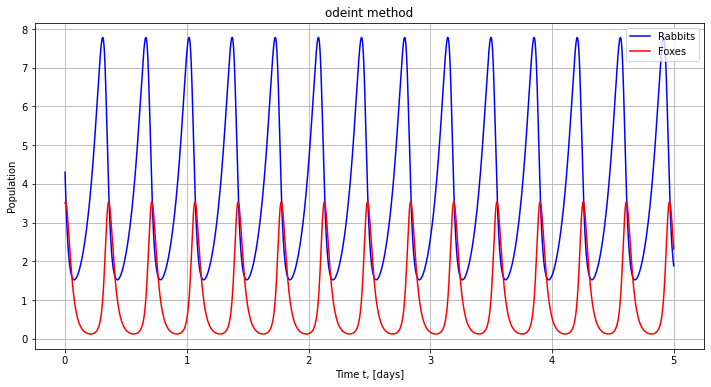

In [112]:
# What we would expect...
# LV rate parameters
sim.alpha = 10.23 # rabbit growth rate
sim.beta = 10.1  # rabbit death rate due to foxes

sim.delta = 39.5 # fox death rate
sim.gamma = 10.3 # fox growth rate due to presence of rabbits

# Initial populations
sim.x0 = 4.3 # rabbits
sim.y0 = 3.5  # foxes

# Solver
sim.h = 0.00001 # Euler integration desired time step


tmax = 5.
t = np.arange(0., tmax, step=sim.h)
# Nt = 1000
# t = np.linspace(0.,tmax, Nt)
X0 = [sim.x0, sim.y0]
# uses LSODA integration algorithm
# See: https://diffeq.sciml.ai/stable/solvers/ode_solve/
res = integrate.odeint(lv_dX, X0, t, args = (sim,)) 
x, y = res.T
print(res.shape, t.shape, x.shape, y.shape)

plt.figure(figsize=(12,6))
plt.grid()
plt.title("odeint method")
plt.plot(t, x, '-b', label = 'Rabbits')
plt.plot(t, y, '-r', label = "Foxes")
plt.xlabel('Time t, [days]')
plt.ylabel('Population')
plt.legend()
plt.show()

Integrating with h=1e-05 (found h=1e-05 in sim)
(500000, 2) (500000,) (500000,) (500000,)


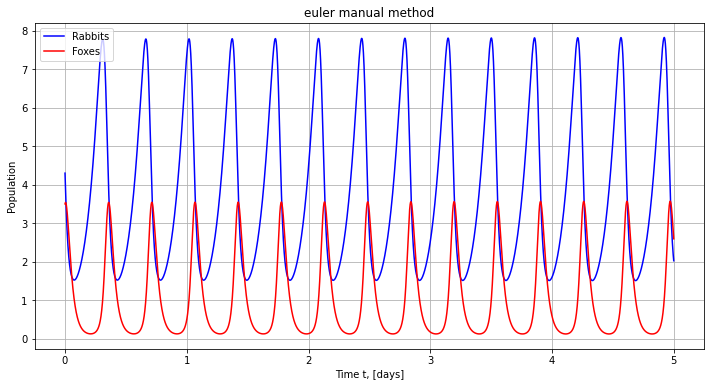

In [113]:
# Using iterative Euler Method

# Adjusting the step size h is very important here
# need a smaller step size for accurate integration on curvy signals
# this makes the computational cost much higher, also potentially gives accumulated error over time...
# trade off a small h against euler_steps_per_message to keep from sending too many OSC messages
# TODO: Alternatively, if such high resolution is needed, send blocks of the time series as a single message
# sim.h = 0.001
# euler_steps_per_message = 100
# message_rate = 0.1
t = np.arange(0., tmax, step=sim.h)
X0 = [sim.x0, sim.y0]

# Integrate for Nt steps
res = euler_integrate(lv_dX, X0, t, sim)

x, y = res.T
print(res.shape, t.shape, x.shape, y.shape)

plt.figure(figsize=(12,6))
plt.grid()
plt.title("euler manual method")
plt.plot(t, x, '-b', label = 'Rabbits')
plt.plot(t, y, '-r', label = "Foxes")
plt.xlabel('Time t, [days]')
plt.ylabel('Population')
plt.legend()

plt.show()

In [123]:
# Stop the simulation...
run_simulation=False
osc_client.send_message(osc_msg_address, ["volume", 0]); # mute sonification

Exit Simulation


In [122]:
# Some reasonable parameters...
message_rate = 0.1
euler_steps_per_message = 100
print_every=10000
send_osc=True
run_simulation=True

['sim', 'LotkaVolterra', 't', 78.40208001368637, 'x', 2.2505866650384547, 'y', 0.7145667273292848]


In [116]:
# Run simulation...
try:
    osc_client.send_message(osc_msg_address, ["volume", 1.0]); #unmute sonification
    loop=asyncio.get_event_loop()
    task=loop.create_task(sim_task())
    #loop.run_until_complete()
    #await task
    print("Finished simulation...")
except KeyboardInterrupt as e:
    exp = traceback.format_exc()
    raise e
except Exception as e:
    exp = traceback.format_exc()
    print("Exit with Errors")
    raise e
finally:
    # Do any necessary cleanup....
    print("Finished...")

Finished simulation...
Finished...
Run Simulation...
['sim', 'LotkaVolterra', 't', 0.0020800000000000046, 'x', 4.947280092845566, 'y', 2.0247875167797926]
['sim', 'LotkaVolterra', 't', 0.02207999999999927, 'x', 4.421268059997235, 'y', 2.210498416297838]
['sim', 'LotkaVolterra', 't', 0.04208000000000221, 'x', 3.8988822920087904, 'y', 2.285166099615628]
['sim', 'LotkaVolterra', 't', 0.06208000000000834, 'x', 3.432637924760417, 'y', 2.244305781120583]
['sim', 'LotkaVolterra', 't', 0.08208000000000087, 'x', 3.0498414006495866, 'y', 2.1095915395284677]
['sim', 'LotkaVolterra', 't', 0.10207999999999312, 'x', 2.7559824041106293, 'y', 1.9150800593279271]
['sim', 'LotkaVolterra', 't', 0.12207999999998537, 'x', 2.543906994111392, 'y', 1.6939333730265582]
['sim', 'LotkaVolterra', 't', 0.14208000000000132, 'x', 2.401775871882155, 'y', 1.4713880222295304]
['sim', 'LotkaVolterra', 't', 0.16208000000002132, 'x', 2.317660169988306, 'y', 1.263390266083105]
['sim', 'LotkaVolterra', 't', 0.18208000000004